# Clustering
This is a notebook for doing some exploratory analysis and plotting. Much of it is not directly used in the report, but has helped formed an understanding etc.


 That includes doing the following: 

- Find a good number of clusters to use for K-Means
- Find reasonable values of eps and num neighbours for DBSCAN
- Test and compare K-Means and DBSCAN
- The notebook also tests some of our implementations on simple test data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from kmeans import KMeans
from dbscan import dbscan

from helpers import calculate_average_radius, scatter, davies_bouldin_score, pca

# Test algorithms on sample data
Lets just test our algorithms on some simple 2D data to make sure they behave as expected

/zhome/c9/c/156514/wiki-suggest/text-processing/helpers.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[:,0], points[:,1], c=colors, cmap="Set1")


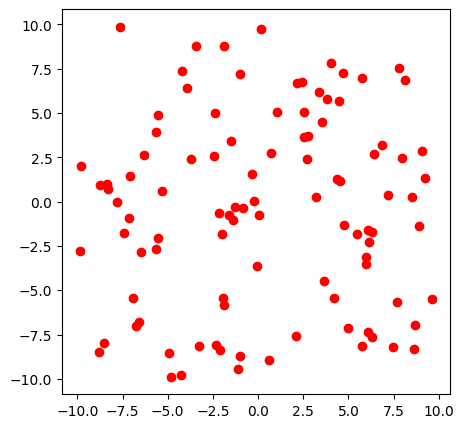

In [2]:
N = 100
points = np.random.uniform(-10, 10, (N, 2))

scatter(points)

### Select K based on average radius

In [3]:
K = 25

radius_scores = []
davies_scores = []

for k in trange(2, K + 1):
    kmeans = KMeans(n_clusters = k, n_iterations = 10)
    labels, centroids = kmeans.cluster(points)
    
    # We return the mean of the average radius per cluster - maybe it should be a mean or something else idk
    radius_scores.append(calculate_average_radius(points, labels, centroids).mean())
    davies_scores.append(davies_bouldin_score(points, labels, centroids))


100%|██████████| 24/24 [00:00<00:00, 35.83it/s]


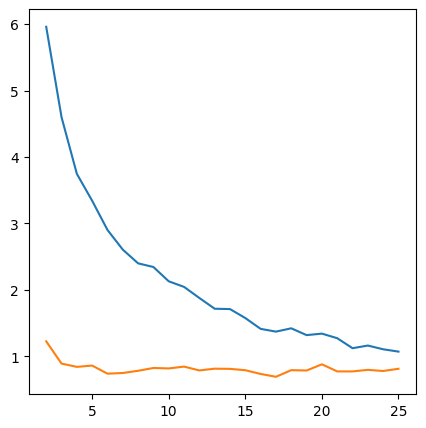

In [4]:
# Note davies-score sucks, or at least doesnt changes the the number of clusters
plt.figure(figsize=(5,5))
plt.plot(range(2, K + 1), radius_scores)
plt.plot(range(2, K + 1), davies_scores)
plt.show()

### K-means algorithm

In [6]:
N_CLUSTERS = 10
kmeans = KMeans(n_clusters = N_CLUSTERS, n_iterations = 10)
labels, centroids = kmeans.cluster(points)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


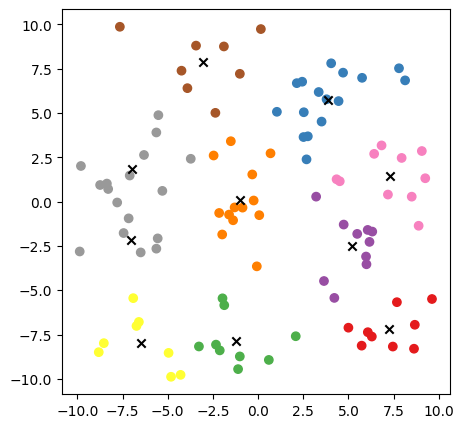

In [7]:
print(set(labels))
scatter(points, centroids=centroids,colors=labels)

### DBSCAN algorithm

In [8]:
labels = dbscan(points.tolist(), eps = 2, min_neighbours = 3, dist_function = "eucliean")

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1}


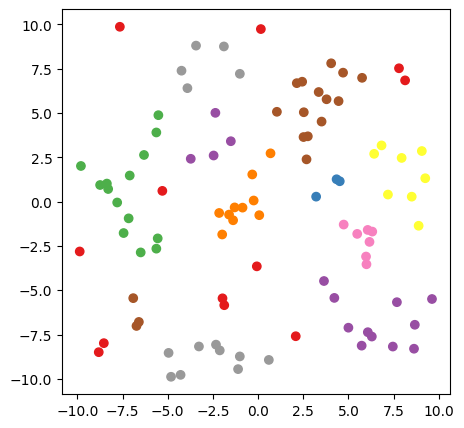

In [9]:
print(set(labels))
scatter(points, colors=labels)

# Using our data
Using the feature vectors of tf-idf or s-bert are high dimensional and not as easily visualized. Buts lets do some exploratory analysis

In [2]:
# Read the feature vectors we have computed earlier using tfidf or sbert
X_tfidf = np.loadtxt("/work3/s204163/wiki/tfidffeatures.csv", delimiter=",")
X_sbert = np.loadtxt("/work3/s204163/wiki/sbertfeatures.csv", delimiter=",")

print(X_tfidf.shape)
print(X_sbert.shape)

(36029, 200)
(36029, 384)


### Finding the ideal number of clusters to use

In [ ]:
from sklearn.utils import shuffle

### Get random subset of the data to make quicker
N = 1000

X_sbert_shuffle, X_tfidf_shuffle = shuffle(X_sbert, X_tfidf, random_state=0)

X_sbert_subset = X_sbert_shuffle[:N,:]
X_tfidf_subset = X_tfidf_shuffle[:N,:]

# Test out different numbers of clusters to use
K = 50

radius_scores = []
davies_scores = []

for k in trange(2, K + 1):
    labels, centroids = KMeans(n_clusters = k).cluster(X_tfidf_subset)
    
    # We return the mean of the average radius per cluster
    radius_scores.append(calculate_average_radius(X_tfidf_subset, labels, centroids).mean())
    davies_scores.append(davies_bouldin_score(X_tfidf_subset, labels, centroids))


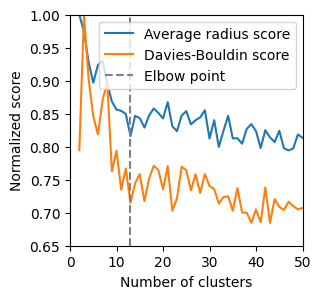

In [53]:
plt.figure(figsize=(3,3))
plt.plot(range(2, K + 1), radius_scores / np.max(radius_scores), label="Average radius score")
plt.plot(range(2, K + 1), davies_scores / np.max(davies_scores), label="Davies-Bouldin score")
plt.xlim(0, 50)
plt.ylim(0.65, 1.0)
plt.vlines(13, plt.ylim()[0], plt.ylim()[1], colors='gray', linestyles='dashed', label="Elbow point")
plt.xlabel("Number of clusters")
plt.ylabel("Normalized score")
plt.legend()
# plt.savefig("../plots/cluster_elbow.svg")
plt.show()

In [3]:
# From the above we can find 13 as a nice elbow point
N_CLUSTERS = 13

# Look at how well KMeans and DBSCAN clusters the data
- We perform KMeans with 13 clusters on both our tf-idf embeddings and our sbert embeddings. 
- We perform DBSCAN on both our tf-idf embeddings and our sbert embeddings. 
- In both cases we use PCA afterwards to downscale to 2 dimensions for plotting

### Kmeans

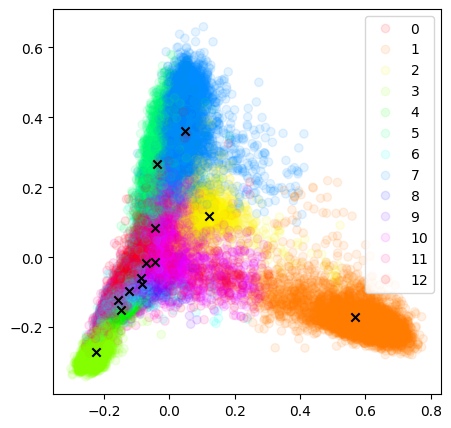

In [4]:
labels_kmeans_tfidf, centroids_kmeans_tfidf = KMeans(n_clusters = N_CLUSTERS).cluster(X_tfidf)

pca(X_tfidf, labels=labels_kmeans_tfidf, centroids=centroids_kmeans_tfidf)

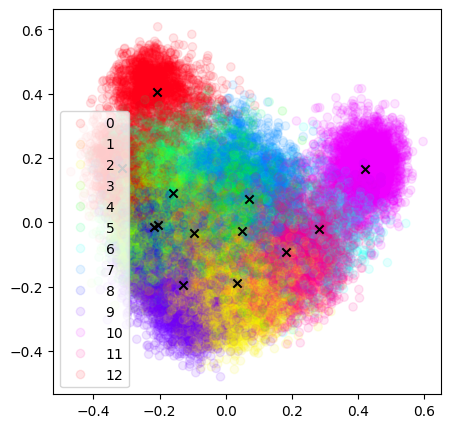

In [5]:
labels_kmeans_sbert, centroids_kmeans_sbert = KMeans(n_clusters = N_CLUSTERS).cluster(X_sbert)

pca(X_sbert, labels=labels_kmeans_sbert, centroids=centroids_kmeans_sbert)

### DBSCAN
We first need to try and develop an intuation about what a good value of eps and min_samples is

In [27]:
longest_dist = 0
longest_pair = None
total_dist = 0.0

for i in trange(X_sbert.shape[0]):
    dists = np.linalg.norm(X_sbert - X_sbert[i,:], axis=1)
    dist = np.max(dists)
    total_dist += np.sum(dists)

    if longest_dist < dist:
        longest_dist = dist
        longest_pair = (i, np.argmax(dists))
        
average_dist = total_dist / (X_sbert.shape[0] ** 2)

print(longest_dist) # 1.447095379214053
print(longest_pair) # (36028, 34789)
print(total_dist)   # 1557499742.6663265
print(average_dist) # 1.1999072445478691

1.447095379214053
(36028, 34789)
1557499742.6663265


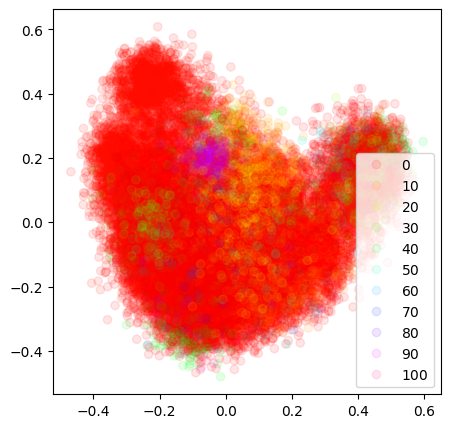

In [6]:
labels_dbscan_sbert = dbscan(X_sbert, eps=0.7, min_neighbours=10)

pca(X_sbert, labels=labels_dbscan_sbert)

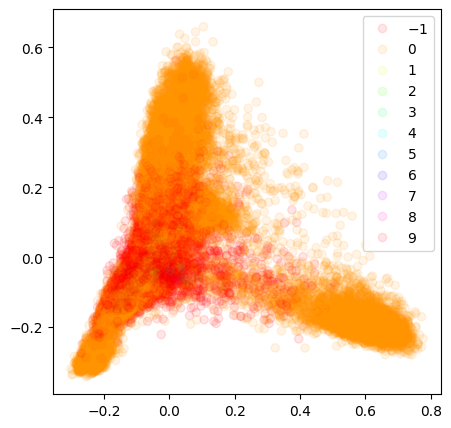

In [7]:
labels_dbscan_tfidf = dbscan(X_tfidf, eps=0.8, min_neighbours=10)

pca(X_tfidf, labels=labels_dbscan_tfidf)

### Plot all PCA outputs together

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsne_ax(ax, X, labels, title = ""):
    # PCA
    pca = PCA(n_components = 10)
    X_pca = pca.fit(X).transform(X) if type(X) == np.ndarray else pca.fit(X.toarray()).transform(X.toarray())

    # TSNE
    X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(X_pca)

    x, y = X_tsne.T
    labels = labels if type(labels) == list else labels.tolist()
    scatter = ax.scatter(x, y, c = labels, cmap="hsv", label = labels, alpha=0.1)
        
    leg = ax.legend(*scatter.legend_elements())
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.set_title(title)

    return ax

In [12]:
from sklearn.decomposition import PCA

def pca_ax(ax, X, labels, centroids = None, title = "", n_components = 2):
    """ Function for using the sklearn pca function for visualizing our clusteirng in 2D """
    pca = PCA(n_components = n_components)
    X_pca = pca.fit(X).transform(X) if type(X) == np.ndarray else pca.fit(X.toarray()).transform(X.toarray())
    
    x, y = X_pca.T
    labels = labels if type(labels) == list else labels.tolist()
    scatter = ax.scatter(x, y, c = labels, cmap="hsv", label = labels, alpha=0.1)
    if not centroids is None:
        centroids = pca.transform(centroids)
        ax.scatter(centroids[:,0], centroids[:,1], c='black', marker='x')
    leg = ax.legend(*scatter.legend_elements())
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    return ax

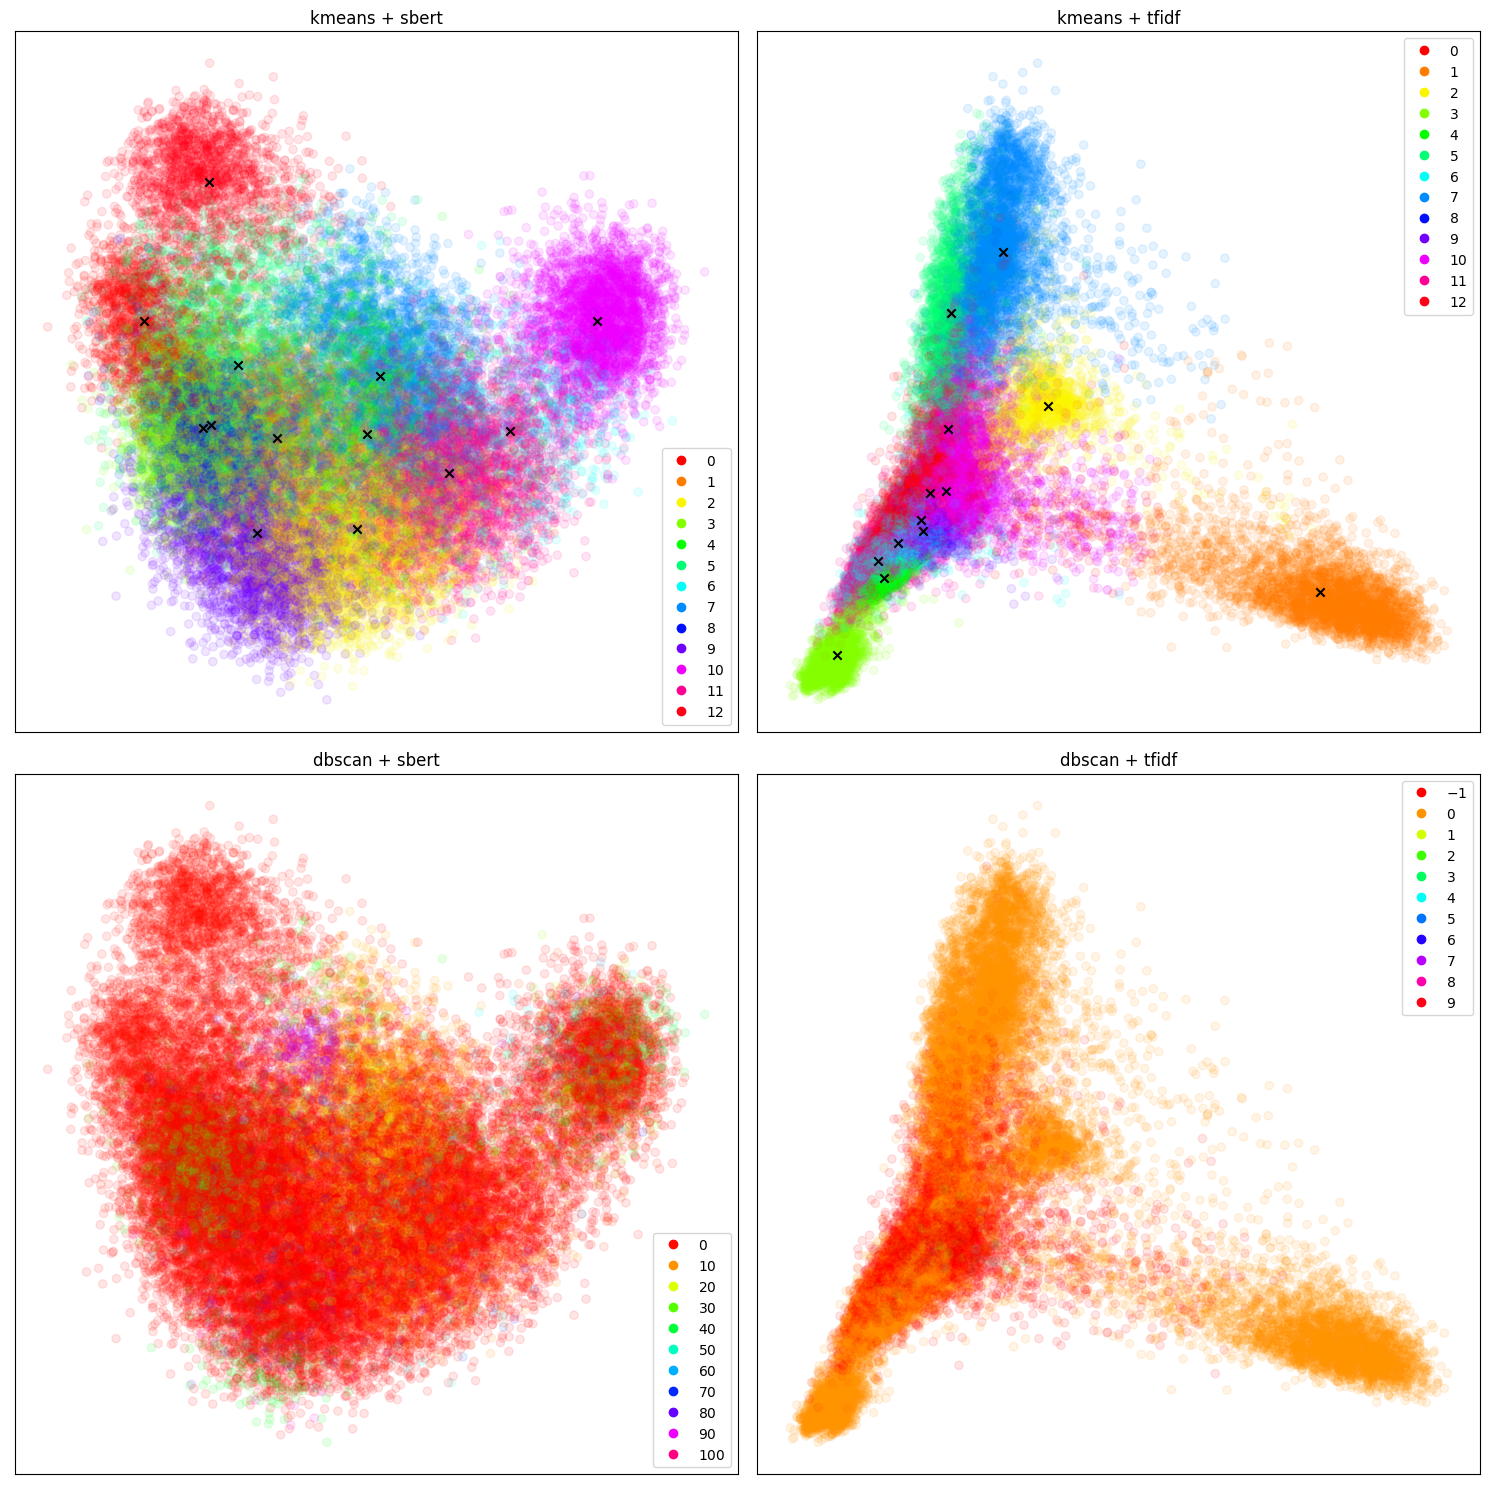

In [13]:
features = [X_sbert, X_tfidf, X_sbert, X_tfidf]
labels = [labels_kmeans_sbert, labels_kmeans_tfidf, labels_dbscan_sbert, labels_dbscan_tfidf]
centroids = [centroids_kmeans_sbert, centroids_kmeans_tfidf, None, None]
titles = ["kmeans + sbert", "kmeans + tfidf", "dbscan + sbert", "dbscan + tfidf"]

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
for i in range(2):
    for j in range(2):
        idx = i*2 + j
        axs[i,j] = pca_ax(axs[i,j], X = features[idx], labels = labels[idx], centroids= centroids[idx], title = titles[idx])
fig.tight_layout()
fig.show()

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [31:05<00:00, 932.75s/it]


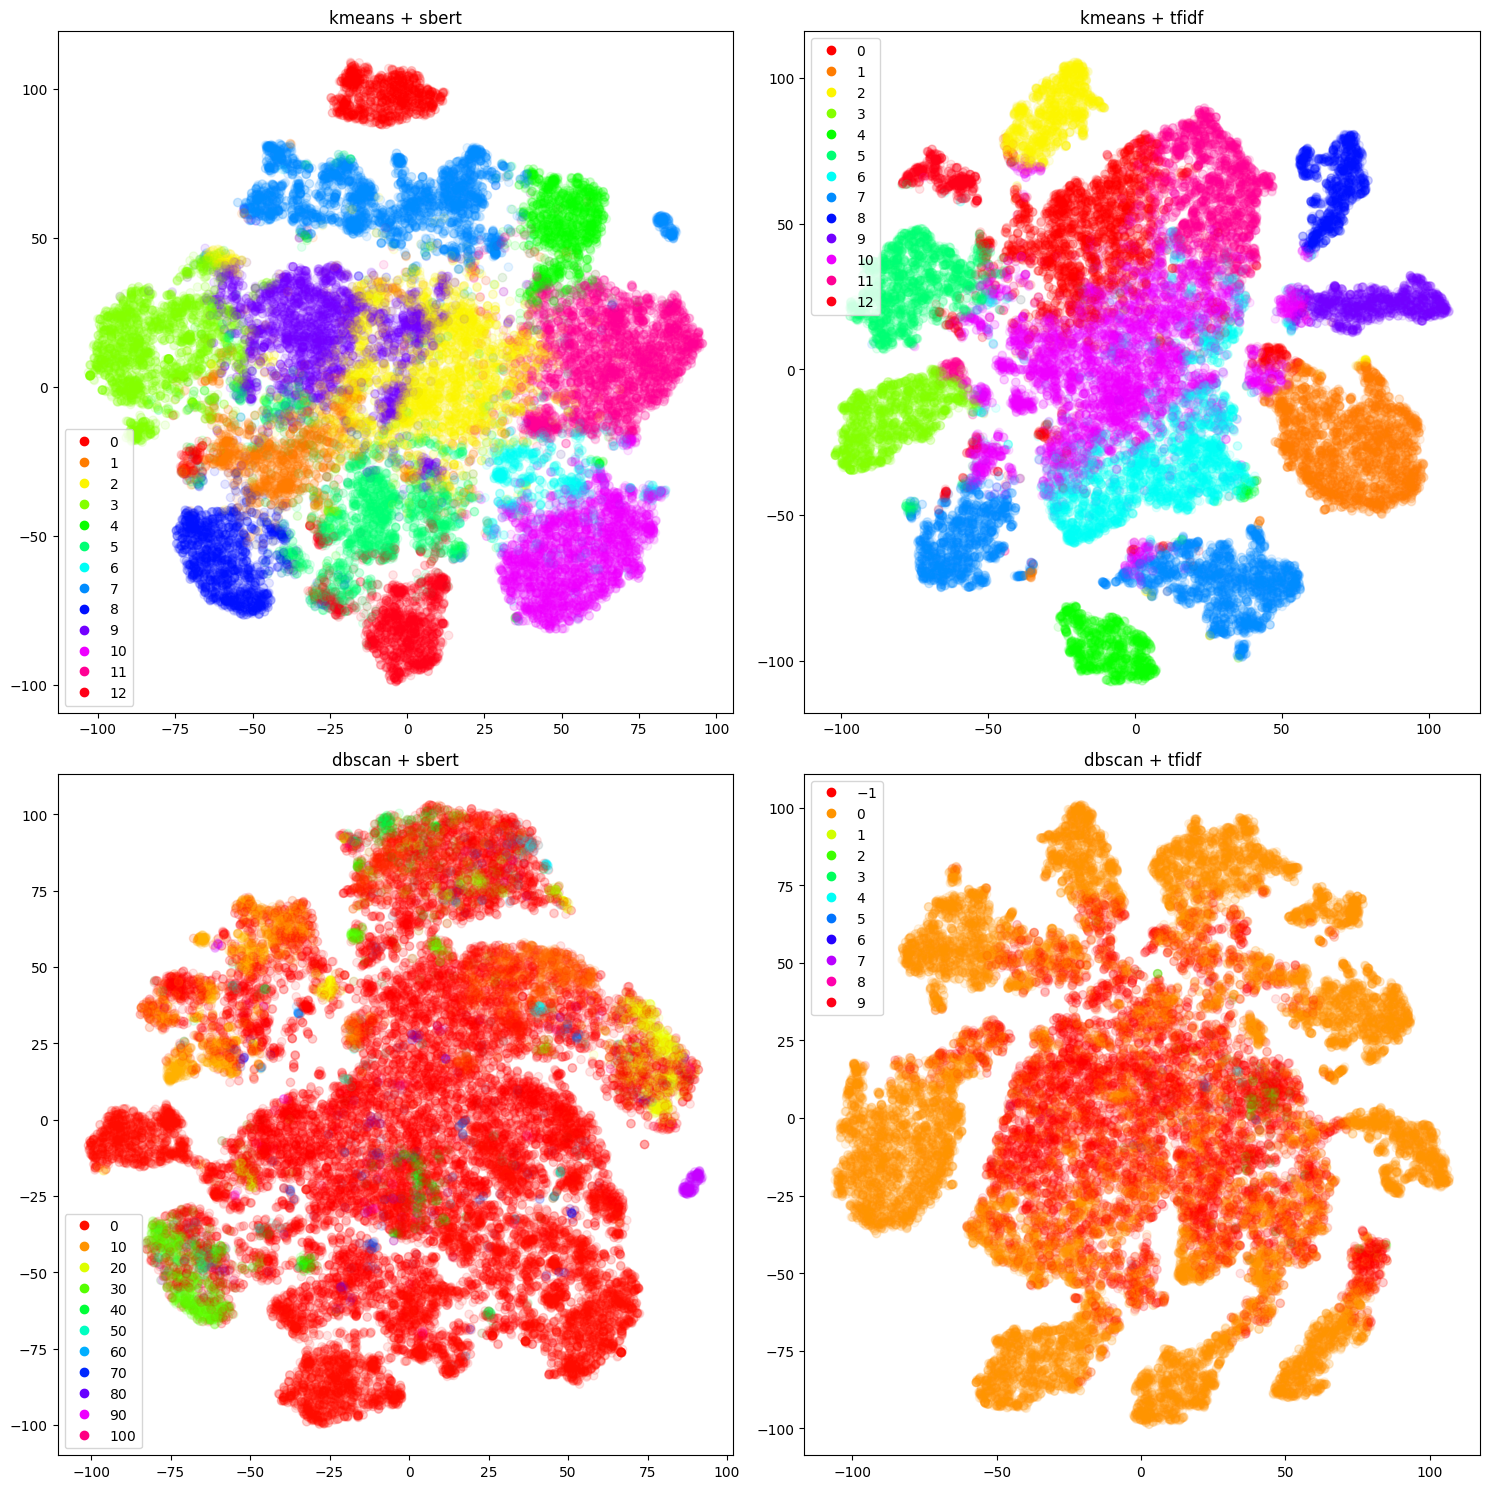

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
for i in trange(2):
    for j in trange(2):
        idx = i*2 + j
        axs[i,j] = tsne_ax(axs[i,j], X = features[idx], labels = labels[idx], title = titles[idx])
fig.tight_layout()
fig.show()